In [20]:
import cv2 as cv
import numpy as np
import os
import shutil
import torch
import random
import torchvision
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image, ImageOps, ImageEnhance
from torchvision.transforms import functional as F

from torch import nn
from tqdm import tqdm
from io import BytesIO

#Para solucionar un posible problema con plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Empezamos recortando las imagenes del dataset por el centroide de la figura

In [21]:
def filter_image(image, debug = 0):
    #Pasamos la imagen a una escala de grises
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #Aplicamos un filtro gausiano para eliminar ruido
    blur = cv.GaussianBlur(gray, (5, 5), 0)
    #Convertimos la imagen a blanco y negro
    ret, thresh = cv.threshold(blur, 75, 255, cv.THRESH_BINARY_INV)
    #Mostramos la imagen si es necesario
    if debug != 0:
        cv.imwrite("filter.png", thresh)
    return ret, thresh

def centroid(image, debug = 0):
    #Encontramos todos los contornos
    contours, hierarchies = cv.findContours(image, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    if len(contours) != 0:  
        #Escogemos el contorno con mayor area
        c = max(contours, key = cv.contourArea)
        #Realizamos el cálculo de los centroides
        M = cv.moments(c)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            if debug != 0:
                print(f"x: {cx} y: {cy}")
    return cx, cy

In [22]:
def crop(path, new_path, type):
    i = 0
    for item in os.listdir(path):
        if os.path.isfile(os.path.join(path, item)):
            image = cv.imread(os.path.join(path, item))
            if image is not None:
                ret, thresh = filter_image(image)
                cx, cy = centroid(thresh)
                w = 215
                imageOut = image[cy-w:cy+w+1, cx-w:cx+w+1]
                #Renombramos los archivos
                name = str(i) + "_" + type + ".png"
                i = i + 1
                try:
                    cv.imwrite(os.path.join(new_path, name), imageOut)
                except:
                    continue

In [23]:
no_fail_path = "Dataset/Original/Sin Fallo"
fail_path = "Dataset/Original/Con Fallo"

new_no_fail_path =  "Dataset/Cortado/Sin Fallo"
new_fail_path =  "Dataset/Cortado/Con Fallo"

if os.path.exists(new_no_fail_path): shutil.rmtree(new_no_fail_path)
os.makedirs(new_no_fail_path)

if os.path.exists(new_fail_path): shutil.rmtree(new_fail_path)
os.makedirs(new_fail_path)

crop(no_fail_path, new_no_fail_path, "nofail")
crop(fail_path, new_fail_path, "fail")

In [24]:
#Comprobamos si disponemos de GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.13.0  Device: cuda


### Una vez preparado el dataset lo dividimos en entrenamiento, validacion y test

In [25]:
def split_data(dataset, test_size=.2):
    L = len(dataset)
    n_second = int(L*test_size)
    n_first = L - n_second
    first_split, second_split = random_split(dataset, lengths=[n_first, n_second])
    return first_split, second_split

In [26]:
DATASET_PATH = "Dataset/Cortado"

dataset = torchvision.datasets.ImageFolder(DATASET_PATH)

training_dataset, validation_dataset = split_data(dataset, test_size = 0.2)
training_dataset, test_dataset = split_data(training_dataset, test_size = 0.1)

In [27]:
class SubsetTransforms(Dataset):
    def __init__(self, subset, transforms):
        self.subset = subset
        self.transforms = transforms
        
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.transforms(x), y

    def __len__(self):
        return len(self.subset)

In [28]:
def show(dataset, N=5, labels=None, figsize=(20, 20)):
    idxs = np.random.randint(0, len(dataset)-1, N)

    fig, axs = plt.subplots(ncols=len(idxs), squeeze=False, figsize=figsize)

    for i, idx in enumerate(idxs):
        sample = dataset[idx]
        
        if isinstance(sample, tuple): # then it is in the form (x, y)
            sample, label = sample
            if isinstance(label, torch.TensorType):
                label = int(label.item())
            if labels:
                label = labels[label]
            axs[0, i].title.set_text(label)

        axs[0, i].imshow(F.to_pil_image(sample))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = [])

    plt.show()

In [29]:
batch_size = 32

transform = transforms.Compose([
                                transforms.Resize((200,200)),
                                transforms.RandomRotation(15),
                                transforms.RandomHorizontalFlip(30),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
                               ])

training_dataset = SubsetTransforms(training_dataset, transform)
test_dataset = SubsetTransforms(test_dataset, transform)
validation_dataset = SubsetTransforms(validation_dataset, transform)

train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


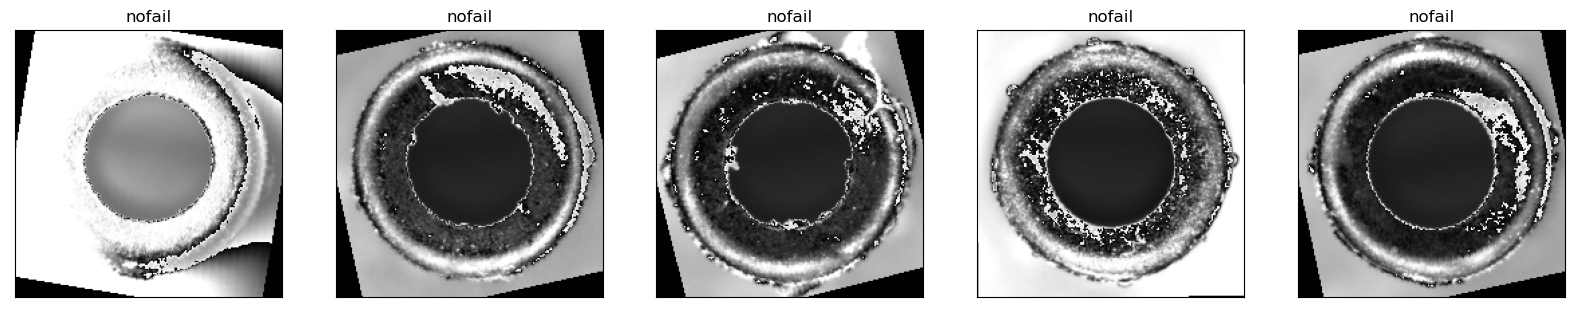

In [30]:
labels_to_idx = {"nofail":1, "fail":0}
idx_to_labels = {0: "fail", 1: "nofail"}

show(training_dataset, labels=idx_to_labels)

In [31]:
def train(epoch, model, optimizer, criterion, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [32]:
def validate(loss_vector, accuracy_vector, model, criterion):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [33]:
def test(model):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            # calculate outputs by running images through the network
            #model = model.cpu()
            outputs = model.cpu()
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct // total}%')

### ResNet18

In [34]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, 2)
        #Solo entrenamos las capas definidas en unfreeze
        unfreeze = ['layer4', 'fc']
        for layer_name, layer in self.model.named_parameters():
            for name in unfreeze:
                if name in layer_name:
                    layer.requires_grad = True
                    break
                else:
                    layer.requires_grad = False
    
    def forward(self, x):
        return self.model(x)

### MyNet

In [35]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(256,512)
        self.dropout = nn.Dropout(0.35)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out

In [36]:
model = MyNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, betas=(0.9, 0.999), eps=1e-8)
criterion = nn.CrossEntropyLoss()

print(model)

MyNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True

Train Epoch: 1 [0/2205 (0%)]	Loss: 0.742765

Validation set: Average loss: 0.1137, Accuracy: 584/612 (95%)

Train Epoch: 2 [0/2205 (0%)]	Loss: 0.204823

Validation set: Average loss: 0.1000, Accuracy: 592/612 (97%)

Train Epoch: 3 [0/2205 (0%)]	Loss: 0.066928

Validation set: Average loss: 0.0546, Accuracy: 600/612 (98%)

Train Epoch: 4 [0/2205 (0%)]	Loss: 0.078553

Validation set: Average loss: 0.0472, Accuracy: 604/612 (99%)

Train Epoch: 5 [0/2205 (0%)]	Loss: 0.021222

Validation set: Average loss: 0.0455, Accuracy: 602/612 (98%)

Train Epoch: 6 [0/2205 (0%)]	Loss: 0.104022

Validation set: Average loss: 0.0868, Accuracy: 596/612 (97%)

Train Epoch: 7 [0/2205 (0%)]	Loss: 0.072564

Validation set: Average loss: 0.0372, Accuracy: 607/612 (99%)

Train Epoch: 8 [0/2205 (0%)]	Loss: 0.009926

Validation set: Average loss: 0.0448, Accuracy: 603/612 (99%)

Train Epoch: 9 [0/2205 (0%)]	Loss: 0.007895

Validation set: Average loss: 0.0416, Accuracy: 605/612 (99%)

Train Epoch: 10 [0/2205 (0%)

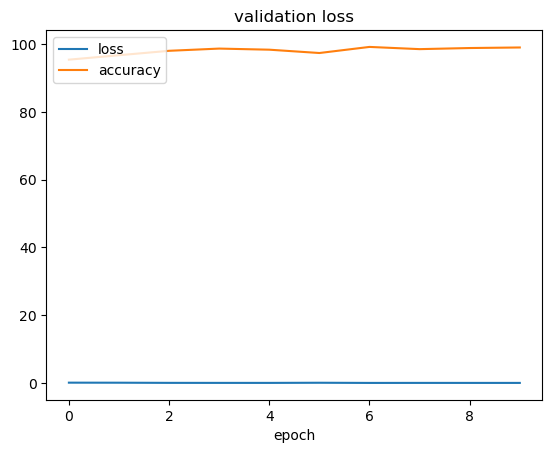

CPU times: total: 14min 2s
Wall time: 3min 48s


In [37]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch, model, optimizer, criterion)
    validate(lossv, accv, model, criterion)
test(model)

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv, label='loss')
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy')

### Realizamos una prueba visual, con 5 imagenes aleatorias del dataset de entrenamiento

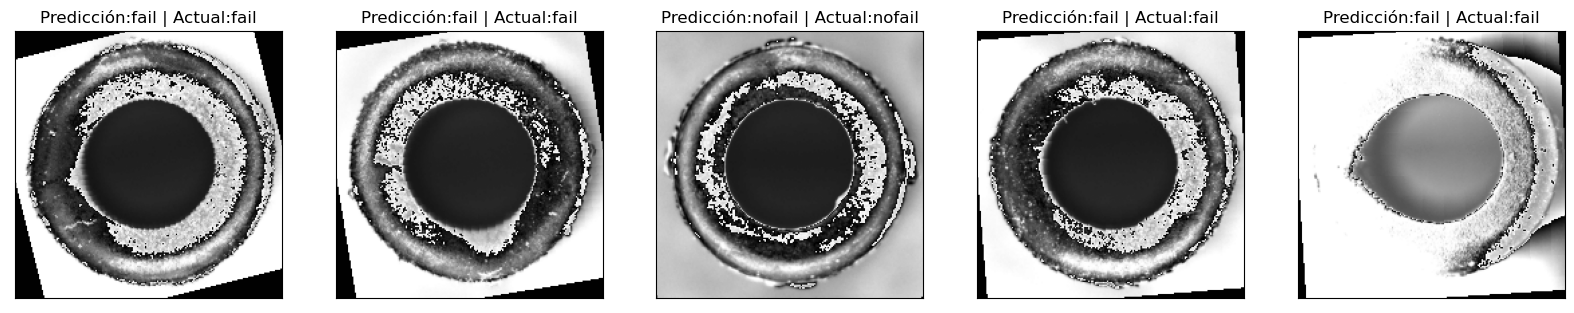

In [38]:
N=5
random_indices = np.random.randint(0, len(test_dataset)-1, N)
random_samples = [test_dataset[i] for i in random_indices]

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20,20))

for i in range(N):
    sample = random_samples[i]
    image, label = sample
    category = idx_to_labels[label]
    
    input_image = image.unsqueeze(0)
    model=model.cpu()
    model_output = model(input_image)
    prediction = torch.argmax(torch.softmax(model_output, -1)).item()
    predicted_category = idx_to_labels[prediction]
    
    axs[i].imshow((image.permute(1, 2, 0) * 255).numpy().astype(np.uint8))
    axs[i].set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    axs[i].set_title(f'Predicción:{predicted_category} | Actual:{category}')
plt.show()